[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZiyuZhang1/computational-tools-for-DS/blob/master/Sentiment_Analysis_yaxin.ipynb)




## **Mount to drive and cd to repo**

In [2]:
%cd '/content/drive/MyDrive/sentiment_analysis'

[Errno 2] No such file or directory: '/content/drive/MyDrive/sentiment_analysis'
/content


In [ ]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers


In [4]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00


## **Load data and do some basic analysis to understand data**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from datasets import load_dataset

In [6]:
dataset = load_dataset("financial_phrasebank","sentences_50agree")
full_data = dataset['train']
df = pd.DataFrame(full_data)

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [117]:
print(df['sentence'])


0       According to Gran , the company has no plans t...
1       Technopolis plans to develop in stages an area...
2       The international electronic industry company ...
3       With the new production plant the company woul...
4       According to the company 's updated strategy f...
                              ...                        
4841    LONDON MarketWatch -- Share prices ended lower...
4842    Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    Operating profit fell to EUR 35.4 mn from EUR ...
4844    Net sales of the Paper segment decreased to EU...
4845    Sales in Finland decreased by 10.5 % in Januar...
Name: sentence, Length: 4846, dtype: object


In [118]:
print(df.shape)

(4846, 2)


In [119]:
df.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2


## **Quick Data Analysis**

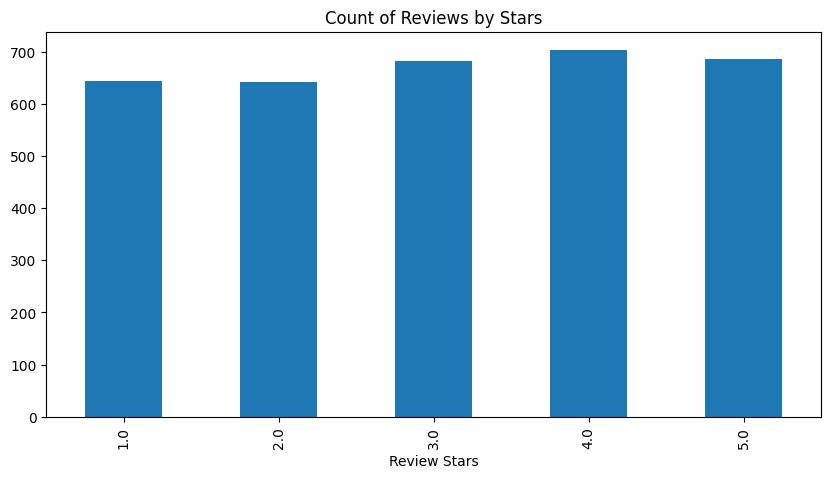

In [ ]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars',
                                               figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

## **NLTK Set Up**

In [7]:
import nltk
nltk.download('punkt')

# loop over each line of the DataFrame，tokenize each line
tokenized_texts = df['sentence'].apply(lambda x: nltk.word_tokenize(str(x)))
print(tokenized_texts.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(4846,)


# **Extracting embedding 2 methods: Word2Vec and Bert**

In [31]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

In [8]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
### Please use GPU for this part, otherwise it will be quite slow
import torch
from tqdm import tqdm  # For progress bar

# Ensure CUDA (GPU) is available and set as the default device, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def encode_sentences(sentences, max_length=512):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
                            sent,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            truncation=True,
                            return_attention_mask=True,
                            return_tensors='pt',
                        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)

    return input_ids, attention_masks

# Function to process sentences in batches
def get_bert_embeddings(sentences, batch_size=128):
    all_embeddings = []

    for start_index in tqdm(range(0, len(sentences), batch_size)):
        batch_sentences = sentences[start_index:start_index+batch_size]
        input_ids, attention_masks = encode_sentences(batch_sentences)

        with torch.no_grad():
            # Move model to the same device as your data
            bert_model.to(device)

            outputs = bert_model(input_ids, attention_mask=attention_masks)
            batch_embeddings = outputs[0].mean(dim=1)  # Average pooling over the token dimension

            # Move embeddings to CPU for further processing or storage
            all_embeddings.append(batch_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

# Process all sentences and get embeddings
embeddings = get_bert_embeddings(df['sentence'])
print(embeddings.shape)



Using device: cuda


100%|██████████| 38/38 [00:57<00:00,  1.52s/it]

torch.Size([4846, 768])


# **Three Clustering Algorithms**


## ***Clustering algorithms in our own code***

###KMeans our code, Word2Vec embeddings as example

In [ ]:
import random

def initialize_centroids(points, k):
    """Randomly initialize centroids"""
    centroids = points.copy()
    random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    """Find the closest centroid for each point"""
    distances = [[sum([(point[dim] - centroid[dim]) ** 2 for dim in range(len(point))]) for centroid in centroids] for point in points]
    return [distances[i].index(min(distances[i])) for i in range(len(distances))]

def recompute_centroids(points, closest, centroids):
    """Recompute centroids"""
    new_centroids = []
    for i in range(len(centroids)):
        assigned_points = [points[j] for j in range(len(points)) if closest[j] == i]
        if assigned_points:
            new_centroids.append([sum(dim)/len(assigned_points) for dim in zip(*assigned_points)])
        else:
            new_centroids.append(centroids[i])
    return new_centroids

def centroids_converged(new_centroids, old_centroids, threshold=0.001):
    """Check if the centroids have converged"""
    for new_centroid, old_centroid in zip(new_centroids, old_centroids):
        if sum((nc - oc)**2 for nc, oc in zip(new_centroid, old_centroid)) > threshold:
            return False
    return True

def kmeans(points, k, max_iterations=100):
    """Main kmeans algorithm"""
    centroids = initialize_centroids(points, k)
    for _ in range(max_iterations):
        closest = closest_centroid(points, centroids)
        new_centroids = recompute_centroids(points, closest, centroids)

        if centroids_converged(new_centroids, centroids):
            break

        centroids = new_centroids
    return closest


k = 3
clusters = kmeans(word_vectors.vectors, k)
print(clusters)



[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 

###DBSCAN our own codes, Word2Vec embeddings as example. **(warning:need more than 60mins in our large dataset)**

In [ ]:
import numpy as np

def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two numpy array points."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def region_query(data, point_idx, eps):
    """Find points within eps distance of the given point."""
    point = data[point_idx]
    return [idx for idx, p in enumerate(data) if euclidean_distance(point, p) < eps]

def expand_cluster(data, classifications, point_idx, cluster_id, eps, min_points):
    """Expand the cluster from the seed point."""
    seeds = region_query(data, point_idx, eps)
    if len(seeds) < min_points:
        classifications[point_idx] = 'Noise'
        return False
    else:
        classifications[point_idx] = cluster_id
        for seed_idx in seeds:
            if classifications[seed_idx] == 'Unvisited':
                classifications[seed_idx] = cluster_id
                seeds.extend(region_query(data, seed_idx, eps))

        seeds = list(set(seeds))  # Remove duplicates
        return True

def dbscan(data, eps, min_points):
    """DBSCAN algorithm implementation."""
    cluster_id = 1
    classifications = {idx: 'Unvisited' for idx in range(len(data))}
    for idx in range(len(data)):
        if classifications[idx] == 'Unvisited':
            if expand_cluster(data, classifications, idx, cluster_id, eps, min_points):
                cluster_id += 1
    return classifications

# Example Usage
eps = 3
min_points = 2
print(word_vectors.vectors)
print(dbscan(word_vectors.vectors, eps, min_points))


[[-6.8026131e-01  2.7910823e-01  1.3686683e+00 ... -5.9905940e-01
  -1.0288619e+00 -2.3889321e-01]
 [-7.5421828e-01  5.1299155e-01  4.5209187e-01 ... -8.7320328e-01
  -1.1502789e+00  6.2682116e-01]
 [-4.4032313e-02 -8.3800685e-01 -1.2664652e+00 ... -9.1260508e-02
  -4.0623911e-02 -2.5103250e-01]
 ...
 [-1.8039229e-03 -5.9758464e-04  7.3238686e-03 ... -5.7185004e-03
   6.7324825e-03 -2.1240956e-03]
 [ 1.1806321e-02  2.5999825e-03  1.0071695e-02 ...  1.5738666e-02
   9.4249006e-03 -7.9516030e-05]
 [-3.8759429e-03 -4.1787205e-03 -1.0980848e-02 ...  9.3190949e-03
  -1.8576713e-02 -1.2787510e-02]]


KeyboardInterrupt: ignored

### CURE our own code, Word2Vec as example

In [12]:
import numpy as np
import random

def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def hierarchical_clustering(data, n_clusters):
    """Perform simple hierarchical clustering to initialize centroids."""
    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    return centroids

def select_representatives(data, centroids, n_representatives, shrink_factor):
    """Select and shrink representatives for each cluster."""
    representatives = {}
    for idx, centroid in enumerate(centroids):
        distances = np.array([euclidean_distance(point, centroid) for point in data])
        furthest_points = data[np.argsort(distances)[-n_representatives:]]
        representatives[idx] = centroid + shrink_factor * (furthest_points - centroid)
    return representatives

def assign_clusters(data, representatives):
    """Assign each data point to the nearest representative."""
    cluster_assignments = np.zeros(len(data))
    for i, point in enumerate(data):
        nearest_cluster = min(representatives.keys(), key=lambda k: euclidean_distance(point, np.mean(representatives[k], axis=0)))
        cluster_assignments[i] = nearest_cluster
    return cluster_assignments

def cure_clustering(data, n_clusters, n_representatives, shrink_factor):
    """CURE algorithm implementation."""
    centroids = hierarchical_clustering(data, n_clusters)
    representatives = select_representatives(data, centroids, n_representatives, shrink_factor)
    return assign_clusters(data, representatives)

# Example Usage
data = word_vectors.vectors
n_clusters = 3
n_representatives = 5
shrink_factor = 0.5
clusters = cure_clustering(data, n_clusters, n_representatives, shrink_factor)
print(clusters)


[0. 0. 0. ... 2. 2. 2.]


# **Clustering Results**

##Word2Vec Clustering results

In [123]:

### KMeans
kmeans = KMeans(n_clusters=3)
# Fit the model
X_KMeans = word_vectors.vectors
KMeans_clusters = kmeans.fit(X_KMeans)
# Getting the cluster labels
KMeans_lables = kmeans.labels_
print("KMeans Cluster assignments:", KMeans_lables)
print(KMeans_lables.shape)

### DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)

X_DBSCAN = word_vectors.vectors
DBSCAN_clusters = dbscan.fit_predict(X_DBSCAN)
DBSCAN_lables = dbscan.labels_
# Output the cluster assignments
print("DBSCAN Cluster assignments:", DBSCAN_lables)

# ### CURE
# X_CURE = word_vectors.vectors
# n_clusters = 3
# n_representatives = 5
# shrink_factor = 0.5
# CURE_clusters = cure_clustering(X_CURE, n_clusters, n_representatives, shrink_factor)

# print("CURE Cluster assignments:", CURE_clusters)


NameError: ignored

##Bert Embeddings Clustering results

In [10]:
# averaged_embeddings = embeddings.mean(dim=0).detach().numpy()

# Define the number of clusters
num_clusters = 3

### KMeans
kmeans = KMeans(n_clusters=num_clusters)
Bert_KMeans_clusters = kmeans.fit_predict(embeddings)
Bert_KMeans_lebles = kmeans.labels_
print("KMeans Cluster assignments using Bert Embeddings:", Bert_KMeans_lebles)
print(Bert_KMeans_lebles.shape)

### DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
Bert_DBSCAN_clusters = dbscan.fit_predict(embeddings)
Bert_DBSCAN_lables = dbscan.labels_
print("DBSCAN Cluster assignments using Bert Embeddings:", Bert_DBSCAN_lables)
print(Bert_DBSCAN_lables.shape)

# ### CURE
# n_clusters = 3
# n_representatives = 5
# shrink_factor = 0.5
# CURE_embeddings = embeddings.numpy()
# Bert_CURE_clusters = cure_clustering(CURE_embeddings, n_clusters, n_representatives, shrink_factor)

# print("CURE Cluster assignments using Bert Embeddings:", Bert_CURE_clusters)
# print(Bert_CURE_clusters.shape)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Cluster assignments using Bert Embeddings: [1 1 1 ... 2 2 2]
(4846,)
DBSCAN Cluster assignments using Bert Embeddings: [-1 -1 -1 ... -1 -1 -1]
(4846,)


In [11]:
print(len(Bert_KMeans_lebles))  # Number of cluster labels
print(df.shape[0])             # Number of rows in DataFrame

# Add the KMeans cluster labels to the DataFrame
df['cluster_label'] = Bert_KMeans_lebles
print(df['cluster_label'])
from sklearn.metrics.pairwise import euclidean_distances

def find_closest_sentences_to_centroids(embeddings, centroids, sentences):
    closest_sentences = []
    for centroid in centroids:
        distances = euclidean_distances([centroid], embeddings)
        closest_sentence_index = distances.argmin()
        closest_sentences.append(sentences[closest_sentence_index])
    return closest_sentences

# Assuming 'embeddings' is your array of sentence embeddings
# and 'df' is your DataFrame with the corresponding sentences
closest_sentences = find_closest_sentences_to_centroids(embeddings, kmeans.cluster_centers_, df['sentence'].tolist())
for i, sentence in enumerate(closest_sentences):
    print(f"Closest sentence to centroid {i}: {sentence}")



4846
4846
0       1
1       1
2       1
3       1
4       2
       ..
4841    2
4842    2
4843    2
4844    2
4845    2
Name: cluster_label, Length: 4846, dtype: int32
Closest sentence to centroid 0: `` Our customers now have the chance to make bookings for all the services they want at one location , '' said Mikko Tuomainen , in-charge of Finnair 's Internet ( sales ) .
Closest sentence to centroid 1: efficiency improvement measures 20 January 2010 - Finnish stationery and gift retailer Tiimari HEL : TII1V said today that it will continue to improve its operational efficiency , by focusing on its profitable core operations .
Closest sentence to centroid 2: Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .


In [36]:
df

,overall,reviewText,Clean_Review,cluster_label
0,1.0,I have been involved with computers for 22 yea...,involve computer year expert design program co...,2
1,1.0,Downloaded KIS7 because previous subscription ...,download previous subscription expire load say...,2
2,1.0,Norton Security has been working fine for the ...,norton security work fine last year start use ...,0
3,1.0,same ol' same ol' from Microsoft - but what ca...,ol ol microsoft expect company large dysfuncti...,2
4,1.0,I have been using Quicken since the 2nd DOS ve...,use quicken since do version cannot understand...,2
...,...,...,...,...
3328,5.0,Used,use,1
3329,5.0,everything ok,everything ok,1
3330,5.0,Video editing and authoring is generally an ex...,video edit author generally expensive proposit...,2
3331,5.0,"Item came quickly, exactly as described, and a...",item come quickly exactly describe great cheap...,1


# **Visualize clustering results**

Wor2Vec Embeddings

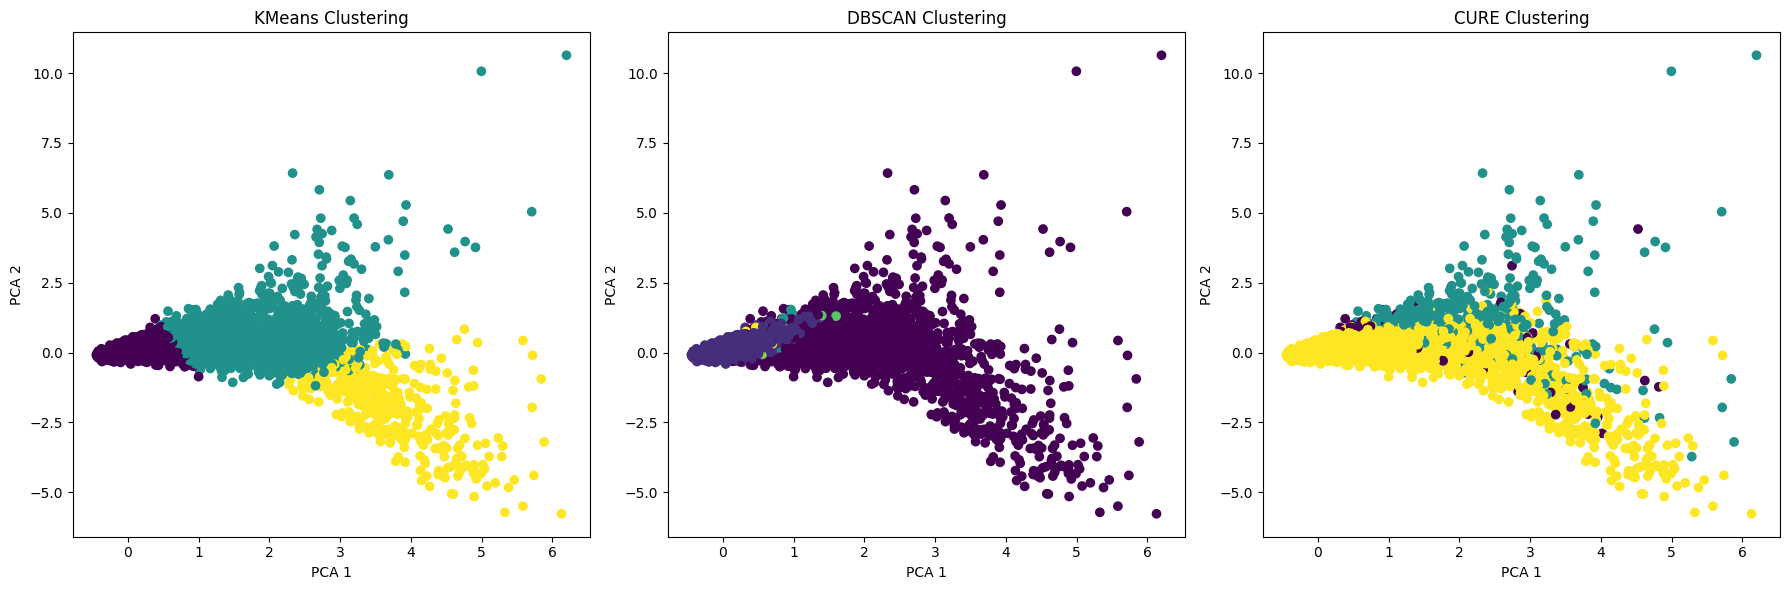

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(X_KMeans)  # Assuming X_KMeans, X_DBSCAN, X_CURE are similar

# Creating a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting KMeans results
axes[0].scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=KMeans_lables, cmap='viridis')
axes[0].set_title('KMeans Clustering')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')

# Plotting DBSCAN results
axes[1].scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=DBSCAN_lables, cmap='viridis')
axes[1].set_title('DBSCAN Clustering')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')

# Plotting CURE results
# Assuming CURE_clusters contains the cluster labels
axes[2].scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=CURE_clusters, cmap='viridis')
axes[2].set_title('CURE Clustering')
axes[2].set_xlabel('PCA 1')
axes[2].set_ylabel('PCA 2')

plt.tight_layout()
plt.show()


Bert Embeddings

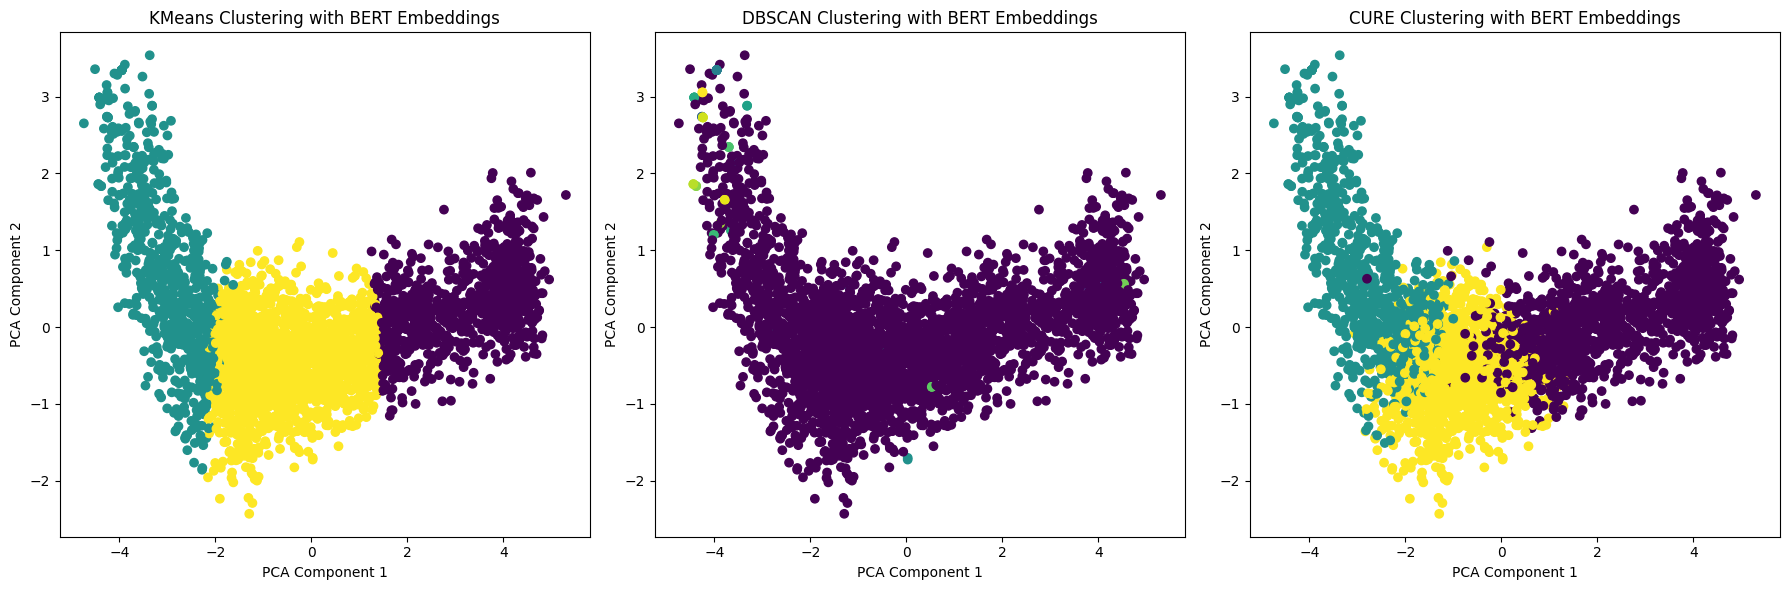

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Creating a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting KMeans results
axes[0].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=Bert_KMeans_lebles, cmap='viridis')
axes[0].set_title('KMeans Clustering with BERT Embeddings')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')

# Plotting DBSCAN results
axes[1].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=Bert_DBSCAN_lables, cmap='viridis')
axes[1].set_title('DBSCAN Clustering with BERT Embeddings')
axes[1].set_xlabel('PCA Component 1')
axes[1].set_ylabel('PCA Component 2')

# Plotting CURE results
axes[2].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=Bert_CURE_clusters, cmap='viridis')
axes[2].set_title('CURE Clustering with BERT Embeddings')
axes[2].set_xlabel('PCA Component 1')
axes[2].set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()




# **Map clusters to sentiment labels**

# **Evaluate Methods using test dataset**

In [16]:
# from datasets import load_dataset

# dataset = load_dataset("financial_phrasebank","sentences_50agree")
# full_data = dataset['train']

# Calculate the number of samples for 10%
sample_size = int(0.001 * len(full_data))

# Random sampling 10% of the data
sample_data = full_data.shuffle(seed=99).select(range(sample_size))

In [17]:
test_data = pd.DataFrame(sample_data)
print(test_data.head())

                                            sentence  label
0              The ECB can mainly target inflation .      1
1  firm 28 October 2009 - Finnish lifting equipme...      2
2  The District Court of Helsinki dismissed all c...      2
3  Finnish fibers and plastic products maker Suom...      2


In [18]:
test_texts = test_data['sentence'].apply(lambda x: nltk.word_tokenize(str(x)))

In [20]:
# Fit k-means clustering on the embeddings
# Ensure the embeddings are converted to float32 before fitting
test_embeddings = get_bert_embeddings(test_texts, batch_size=32).numpy().astype('float32')
kmeans.fit(test_embeddings)

# Now make sure to convert embeddings to float32 when predicting as well
def predict_cluster(sentences, kmeans_model, batch_size=128):
    test_embeddings = get_bert_embeddings(sentences, batch_size).numpy().astype('float32')
    closest_clusters = kmeans_model.predict(test_embeddings)
    return closest_clusters

# Your test_data['sentence'] should then be processed with the predict_cluster function
closest_clusters = predict_cluster(test_texts.tolist(), kmeans, batch_size=32)

# Add the cluster predictions to your test DataFrame
test_data['predicted_cluster'] = closest_clusters
def switch_labels(label):
    if label == 0:
        return 2
    elif label == 2:
        return 0
    else:
        return label

# Apply the function to switch labels
test_data['switched_predicted_cluster'] = test_data['predicted_cluster'].apply(switch_labels)

# Now, test_data has a new column 'switched_predicted_cluster' with the switched labels


# Compute accuracy
accuracy = (test_data['label'] == test_data['switched_predicted_cluster']).mean()
print(f"Accuracy: {accuracy}")


100%|██████████| 1/1 [00:00<00:00, 14.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 14.27it/s]

Accuracy: 0.5


In [32]:
# from datasets import load_dataset

# dataset = load_dataset("financial_phrasebank","sentences_50agree")
# full_data = dataset['train']

# Calculate the number of samples for 10%
sample_size = int(0.001 * len(full_data))

# Random sampling 10% of the data
sample_data = full_data.shuffle(seed=99).select(range(sample_size))
test_texts = test_data['sentence'].apply(lambda x: nltk.word_tokenize(str(x)))
# Fit k-means clustering on the embeddings
# Ensure the embeddings are converted to float32 before fitting
test_embeddings = get_bert_embeddings(test_texts, batch_size=32).numpy().astype('float32')
kmeans.fit(test_embeddings)

# Now make sure to convert embeddings to float32 when predicting as well
def predict_cluster(sentences, kmeans_model, batch_size=128):
    test_embeddings = get_bert_embeddings(sentences, batch_size).numpy().astype('float32')
    closest_clusters = kmeans_model.predict(test_embeddings)
    return closest_clusters

# Your test_data['sentence'] should then be processed with the predict_cluster function
closest_clusters = predict_cluster(test_texts.tolist(), kmeans, batch_size=32)

# Add the cluster predictions to your test DataFrame
test_data['predicted_cluster'] = closest_clusters
def switch_labels(label):
    if label == 0:
        return 2
    elif label == 2:
        return 0
    else:
        return label

# Apply the function to switch labels
test_data['switched_predicted_cluster'] = test_data['predicted_cluster'].apply(switch_labels)

# Now, test_data has a new column 'switched_predicted_cluster' with the switched labels


# Compute accuracy
accuracy = (test_data['label'] == test_data['switched_predicted_cluster']).mean()
print(f"Accuracy: {accuracy}")


100%|██████████| 1/1 [00:00<00:00, 16.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 20.71it/s]

Accuracy: 0.75
